# ASAP Discovery Challenge - March 2025

This notebook implements a transfer learning approach for the ASAP Discovery competition:
1. Train a base GP model on a larger MPRO dataset (2k data points)
2. Fine-tune separate models for SARS-CoV-2 and MERS-CoV using the competition data
3. Generate predictions and submit them to the competition


In [1]:
# Antiviral Potency Prediction with Transfer Learning


# -------------------------------------------------
# 1. Setup and Imports
# -------------------------------------------------

import sys
import os
import numpy as np
import pandas as pd
import torch
import gpytorch
import datamol as dm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Navigate to project root
root_dir = os.path.abspath(os.path.join(os.getcwd(), "DD"))
sys.path.append(root_dir)

# Import project utilities
from utils import *
import polaris as po

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:
# Set up device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:

# -------------------------------------------------
# 2. Load and Preprocess Data
# -------------------------------------------------

# 2.1 Load competition data
print("Loading competition data...")
CHALLENGE = "antiviral-potency-2025"
competition = po.load_competition(f"asap-discovery/{CHALLENGE}")
competition.cache()

# Get train-test split
train, test = competition.get_train_test_split()

# 2.2 Process competition data
print("Processing competition data...")
# Extract data into lists
smiles = []
pIC50_MERS = []
pIC50_SARS = []

# Iterate through dataset
for i in range(len(train)):
    item = train[i]
    # Extract SMILES string
    smiles.append(item[0])
    # Extract pIC50 values
    pIC50_MERS.append(item[1]['pIC50 (MERS-CoV Mpro)'])
    pIC50_SARS.append(item[1]['pIC50 (SARS-CoV-2 Mpro)'])

# Create and clean DataFrame
mpro_df_comp = pd.DataFrame({
    'SMILES': smiles,
    'pIC50_MERS': pIC50_MERS,
    'pIC50_SARS': pIC50_SARS
})
mpro_df_comp = mpro_df_comp.dropna()  # Remove rows with missing values

# 2.3 Load and process MPRO dataset (2k data points)
print("Loading MPRO dataset...")
mpro_dataset = pd.read_csv('DD/data/Mpro_sorted.csv')
# Select relevant columns and clean data
mpro_dataset = mpro_dataset[['SMILES', 'affinity']]
mpro_dataset.dropna(inplace=True)

# Convert SMILES to molecular fingerprints
print("Converting SMILES to fingerprints...")

# MPRO dataset fingerprints
X_mpro = []
Y_mpro = []
for i, row in mpro_dataset.iterrows():
    try:
        mol = dm.to_mol(row['SMILES'])
        if mol is not None:
            X_mpro.append(dm.to_fp(mol))
            Y_mpro.append(row['affinity'])
    except Exception as e:
        print(f"Error processing molecule {i}: {e}")

X_mpro = np.array(X_mpro)
Y_mpro = np.array(Y_mpro)

# Competition dataset fingerprints
X_train_comp = []
for smi in mpro_df_comp['SMILES']:
    try:
        mol = dm.to_mol(smi)
        if mol is not None:
            X_train_comp.append(dm.to_fp(mol))
    except Exception as e:
        print(f"Error processing molecule: {e}")

X_train_comp = np.array(X_train_comp)
Y_sars = mpro_df_comp['pIC50_SARS'].to_numpy()
Y_mers = mpro_df_comp['pIC50_MERS'].to_numpy()

# Test dataset fingerprints
X_test = []
for smi in test.X:
    try:
        mol = dm.to_mol(smi)
        if mol is not None:
            X_test.append(dm.to_fp(mol))
    except Exception as e:
        print(f"Error processing test molecule: {e}")

X_test = np.array(X_test)

# When creating tensors:
X_mpro_tensor = torch.tensor(X_mpro, dtype=torch.float32).to(device)  
Y_mpro_tensor = torch.tensor(Y_mpro, dtype=torch.float32).to(device)

X_train_comp_tensor = torch.tensor(X_train_comp, dtype=torch.float32).to(device)  
Y_sars_tensor = torch.tensor(Y_sars, dtype=torch.float32).to(device)
Y_mers_tensor = torch.tensor(Y_mers, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  

print(f"MPRO dataset: {len(X_mpro)} molecules")
print(f"Competition training data: {len(X_train_comp)} molecules")
print(f"Test data: {len(X_test)} molecules")

Loading competition data...


[2025-03-03 16:23:06] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=895608;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=824671;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.9).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=874304;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=174208;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

Output()

[16:23:06] Copying to destination                                                                      ]8;id=655605;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=391325;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py#380\380]8;;\
           /home/zeus/.cache/polaris/datasets/eb43e111-71f7-48f3-8140-3337ee834e61/data.zarr                       

           For large Zarr archives, this may take a while.                                             ]8;id=141923;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=890035;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/dataset/_base.py#381\381]8;;\

[16:23:07]  Success: Copying Zarr keys                                                                ]8;id=281604;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=190216;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=354488;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=665872;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

Processing competition data...
Loading MPRO dataset...
Converting SMILES to fingerprints...
MPRO dataset: 2062 molecules
Competition training data: 712 molecules
Test data: 297 molecules


In [4]:
# -------------------------------------------------
# 3. Model Definition
# -------------------------------------------------

class TanimotoKernel(gpytorch.kernels.Kernel):
    """
    A custom kernel implementing the Tanimoto similarity for GPyTorch models.
    
    The Tanimoto kernel is particularly useful for binary data, such as molecular fingerprints.
    It computes the similarity between two binary vectors using the Tanimoto coefficient.
    """
    
    def __init__(self, **kwargs):
        """Initialize the TanimotoKernel."""
        super(TanimotoKernel, self).__init__(**kwargs)
        self.register_parameter(name="raw_lengthscale", parameter=torch.nn.Parameter(torch.zeros(1)))
    
    def forward(self, x1, x2, diag=False, **params):
        """Compute the Tanimoto similarity between two sets of inputs."""
        if diag:
            return self.covar_dist(x1, x2, diag=True, **params)
        else:
                    # Ensure inputs are float tensors for GPU compatibility
            x1 = x1.to(torch.float32)
            x2 = x2.to(torch.float32)
            
            x1_norm = x1.pow(2).sum(dim=-1, keepdim=True)
            x2_norm = x2.pow(2).sum(dim=-1, keepdim=True)
            x1_dot_x2 = torch.matmul(x1, x2.transpose(-1, -2))
            denominator = x1_norm + x2_norm.transpose(-1, -2) - x1_dot_x2
            return x1_dot_x2 / denominator.clamp(min=1e-8)

class GPRegressionModel(gpytorch.models.ExactGP):
    """
    A Gaussian Process Regression model with configurable kernels.
    
    This model is designed for exact GP inference and is particularly suited for
    regression tasks with molecular fingerprints.
    """
    
    def __init__(self, train_x, train_y, likelihood, kernel_type="linear"):
        """Initialize the GPRegressionModel."""
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Select kernel based on kernel_type
        if kernel_type == "linear":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
            print(f"Using Linear kernel for model")
        elif kernel_type == "tanimoto":
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoKernel())
            print(f"Using Tanimoto kernel for model")
        elif kernel_type == "rbf":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            print(f"Using RBF kernel for model")
        elif kernel_type == "matern":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
            print(f"Using Matern kernel for model")
        elif kernel_type == "rq":
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
            print(f"Using RQ kernel for model")
        else:
            # Default to linear kernel
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
            print(f"Unknown kernel '{kernel_type}', using Linear kernel as default")
    
    def forward(self, x):
        """Define the computational graph for the GP model."""
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [5]:
# -------------------------------------------------
# 4. Training Function
# -------------------------------------------------

def train_gp_model(train_x, train_y, likelihood, model, epochs=100, lr=0.1, lr_decay=0.95, verbose=True):
    """
    Train a Gaussian Process regression model with GPU support.
    
    Parameters:
    -----------
    train_x : torch.Tensor
        Training input data.
    train_y : torch.Tensor
        Training target values.
    likelihood : gpytorch.likelihoods.GaussianLikelihood
        The likelihood for the GP model.
    model : GPRegressionModel
        The GP model to train.
    epochs : int
        Number of training epochs.
    lr : float
        Initial learning rate.
    lr_decay : float
        Learning rate decay factor.
    verbose : bool
        Whether to print progress information.
        
    Returns:
    --------
    model : GPRegressionModel
        Trained GP model.
    likelihood : gpytorch.likelihoods.GaussianLikelihood
        Trained likelihood.
    losses : list
        Training loss history.
    """
    # Ensure model and likelihood are on the correct device
    device = train_x.device
    model = model.to(device)
    likelihood = likelihood.to(device)
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    losses = []
    
    # Use context manager for faster GPU training
    with gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        for i in range(epochs):
            # Training step
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            losses.append(loss.item())
            
            if verbose and (i+1) % 10 == 0:
                print(f"Epoch {i+1}/{epochs} | Loss: {loss.item():.3f} | Device: {device}")
            
            loss.backward()
            optimizer.step()
            scheduler.step()
    
    return model, likelihood, losses


Training base model on MPRO dataset...
Using Tanimoto kernel for model


Epoch 10/1500 | Loss: 1.974 | Device: cpu
Epoch 20/1500 | Loss: 1.938 | Device: cpu
Epoch 30/1500 | Loss: 1.917 | Device: cpu
Epoch 40/1500 | Loss: 1.895 | Device: cpu
Epoch 50/1500 | Loss: 1.881 | Device: cpu
Epoch 60/1500 | Loss: 1.871 | Device: cpu
Epoch 70/1500 | Loss: 1.859 | Device: cpu
Epoch 80/1500 | Loss: 1.851 | Device: cpu
Epoch 90/1500 | Loss: 1.848 | Device: cpu
Epoch 100/1500 | Loss: 1.847 | Device: cpu
Epoch 110/1500 | Loss: 1.835 | Device: cpu
Epoch 120/1500 | Loss: 1.833 | Device: cpu
Epoch 130/1500 | Loss: 1.833 | Device: cpu
Epoch 140/1500 | Loss: 1.829 | Device: cpu
Epoch 150/1500 | Loss: 1.828 | Device: cpu
Epoch 160/1500 | Loss: 1.818 | Device: cpu
Epoch 170/1500 | Loss: 1.818 | Device: cpu
Epoch 180/1500 | Loss: 1.822 | Device: cpu
Epoch 190/1500 | Loss: 1.818 | Device: cpu
Epoch 200/1500 | Loss: 1.821 | Device: cpu
Epoch 210/1500 | Loss: 1.818 | Device: cpu
Epoch 220/1500 | Loss: 1.813 | Device: cpu
Epoch 230/1500 | Loss: 1.814 | Device: cpu
Epoch 240/1500 | Los

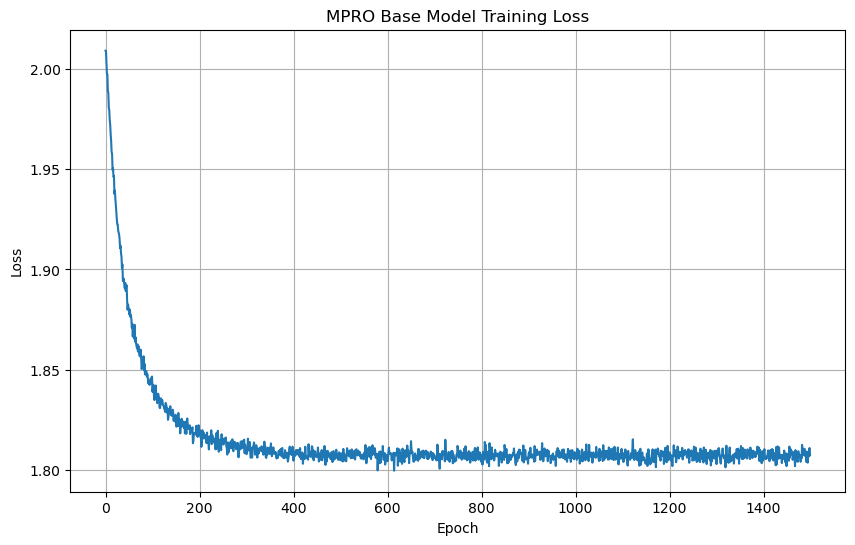

In [6]:
# -------------------------------------------------
# 5. Transfer Learning Implementation
# -------------------------------------------------

# 5.1 Train base model on MPRO dataset
print("\nTraining base model on MPRO dataset...")
likelihood_mpro = gpytorch.likelihoods.GaussianLikelihood()
model_mpro = GPRegressionModel(X_mpro_tensor, Y_mpro_tensor, likelihood_mpro, kernel_type="tanimoto")

# GPU memory management for large datasets
# Monitor memory usage 
if torch.cuda.is_available():
    print(f"GPU memory before training: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

# Use larger cholesky jitter for numerical stability on GPU
with gpytorch.settings.cholesky_jitter(1e-4):
    model_mpro, likelihood_mpro, losses_mpro = train_gp_model(
        train_x=X_mpro_tensor,
        train_y=Y_mpro_tensor,
        likelihood=likelihood_mpro,
        model=model_mpro,
        epochs=1500,  # More epochs for base model
        lr=0.01,
        lr_decay=0.99
    )

if torch.cuda.is_available():
    print(f"GPU memory after training: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses_mpro)
plt.title('MPRO Base Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Initializing target-specific models with base model weights...
Using Tanimoto kernel for model
Using Tanimoto kernel for model

Fine-tuning SARS-CoV-2 model...


Epoch 10/700 | Loss: 1.307 | Device: cpu
Epoch 20/700 | Loss: 1.300 | Device: cpu
Epoch 30/700 | Loss: 1.293 | Device: cpu
Epoch 40/700 | Loss: 1.287 | Device: cpu
Epoch 50/700 | Loss: 1.281 | Device: cpu
Epoch 60/700 | Loss: 1.276 | Device: cpu
Epoch 70/700 | Loss: 1.272 | Device: cpu
Epoch 80/700 | Loss: 1.268 | Device: cpu
Epoch 90/700 | Loss: 1.265 | Device: cpu
Epoch 100/700 | Loss: 1.261 | Device: cpu
Epoch 110/700 | Loss: 1.259 | Device: cpu
Epoch 120/700 | Loss: 1.256 | Device: cpu
Epoch 130/700 | Loss: 1.254 | Device: cpu
Epoch 140/700 | Loss: 1.252 | Device: cpu
Epoch 150/700 | Loss: 1.250 | Device: cpu
Epoch 160/700 | Loss: 1.248 | Device: cpu
Epoch 170/700 | Loss: 1.247 | Device: cpu
Epoch 180/700 | Loss: 1.246 | Device: cpu
Epoch 190/700 | Loss: 1.244 | Device: cpu
Epoch 200/700 | Loss: 1.243 | Device: cpu
Epoch 210/700 | Loss: 1.242 | Device: cpu
Epoch 220/700 | Loss: 1.242 | Device: cpu
Epoch 230/700 | Loss: 1.241 | Device: cpu
Epoch 240/700 | Loss: 1.240 | Device: cpu
E

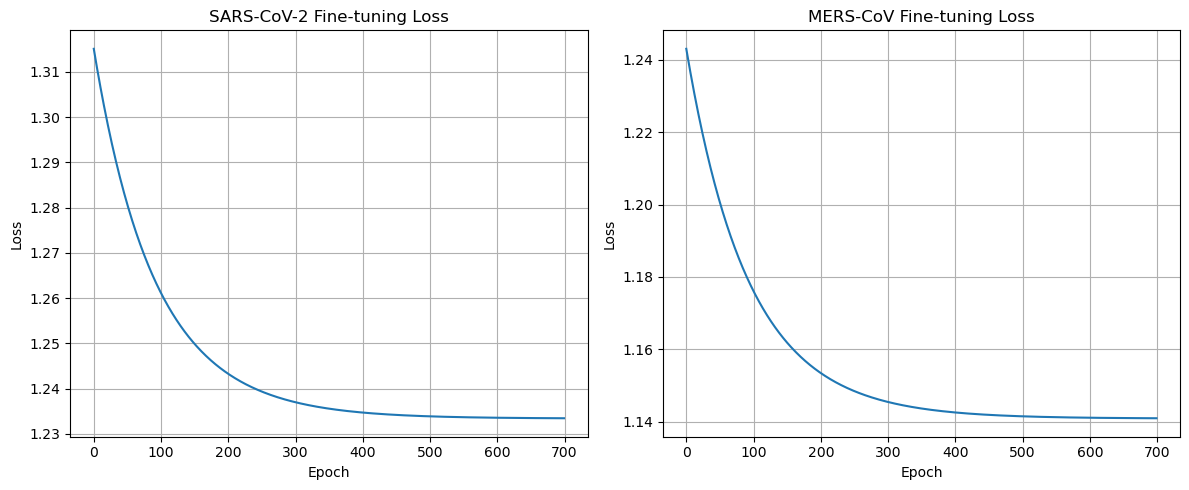

In [7]:
# 5.2 Initialize SARS and MERS models with MPRO model weights
print("\nInitializing target-specific models with base model weights...")

# For SARS-CoV-2
likelihood_sars = gpytorch.likelihoods.GaussianLikelihood()
model_sars = GPRegressionModel(X_train_comp_tensor, Y_sars_tensor, likelihood_sars, kernel_type="tanimoto")
# Copy weights from base model
model_sars.covar_module.load_state_dict(model_mpro.covar_module.state_dict())
model_sars.mean_module.load_state_dict(model_mpro.mean_module.state_dict())

# For MERS-CoV
likelihood_mers = gpytorch.likelihoods.GaussianLikelihood()
model_mers = GPRegressionModel(X_train_comp_tensor, Y_mers_tensor, likelihood_mers, kernel_type="tanimoto")
# Copy weights from base model
model_mers.covar_module.load_state_dict(model_mpro.covar_module.state_dict())
model_mers.mean_module.load_state_dict(model_mpro.mean_module.state_dict())

# 5.3 Fine-tune models on target-specific data
print("\nFine-tuning SARS-CoV-2 model...")
model_sars, likelihood_sars, losses_sars = train_gp_model(
    train_x=X_train_comp_tensor,
    train_y=Y_sars_tensor,
    likelihood=likelihood_sars,
    model=model_sars,
    epochs=700,  # Fewer epochs for fine-tuning
    lr=0.005,    # Lower learning rate for fine-tuning
    lr_decay=0.99
)

print("\nFine-tuning MERS-CoV model...")
model_mers, likelihood_mers, losses_mers = train_gp_model(
    train_x=X_train_comp_tensor,
    train_y=Y_mers_tensor,
    likelihood=likelihood_mers,
    model=model_mers,
    epochs=700,  # Fewer epochs for fine-tuning
    lr=0.005,    # Lower learning rate for fine-tuning
    lr_decay=0.99
)

# Plot fine-tuning losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_sars)
plt.title('SARS-CoV-2 Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses_mers)
plt.title('MERS-CoV Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
# Check if parameters are trainable
print(model_sars.covar_module.raw_outputscale.requires_grad)  # Should be True

True


In [9]:
# -------------------------------------------------
# 6. Generate Predictions
# -------------------------------------------------

print("\nGenerating predictions...")
model_sars.eval()
likelihood_sars.eval()
model_mers.eval()
likelihood_mers.eval()

# Use batch prediction if dataset is large to avoid GPU memory issues
batch_size = 512  # Adjust based on your GPU memory
means_sars = []
vars_sars = []
means_mers = []
vars_mers = []

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # Process in batches to handle large datasets
    for i in range(0, X_test_tensor.size(0), batch_size):
        X_batch = X_test_tensor[i:i+batch_size]
        
        # SARS-CoV-2 predictions
        f_preds_sars = model_sars(X_batch)
        means_sars.append(f_preds_sars.mean.cpu().numpy())
        vars_sars.append(f_preds_sars.variance.cpu().numpy())
        
        # MERS-CoV predictions
        f_preds_mers = model_mers(X_batch)
        means_mers.append(f_preds_mers.mean.cpu().numpy())
        vars_mers.append(f_preds_mers.variance.cpu().numpy())
        
        if i % (batch_size * 4) == 0 and i > 0:
            print(f"Processed {i}/{X_test_tensor.size(0)} test molecules")

# Concatenate batch results
mean_sars = np.concatenate(means_sars)
var_sars = np.concatenate(vars_sars)
mean_mers = np.concatenate(means_mers)
var_mers = np.concatenate(vars_mers)

# Create prediction dictionary for submission
y_pred = {
    'pIC50 (SARS-CoV-2 Mpro)': mean_sars,
    'pIC50 (MERS-CoV Mpro)': mean_mers
}





Generating predictions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


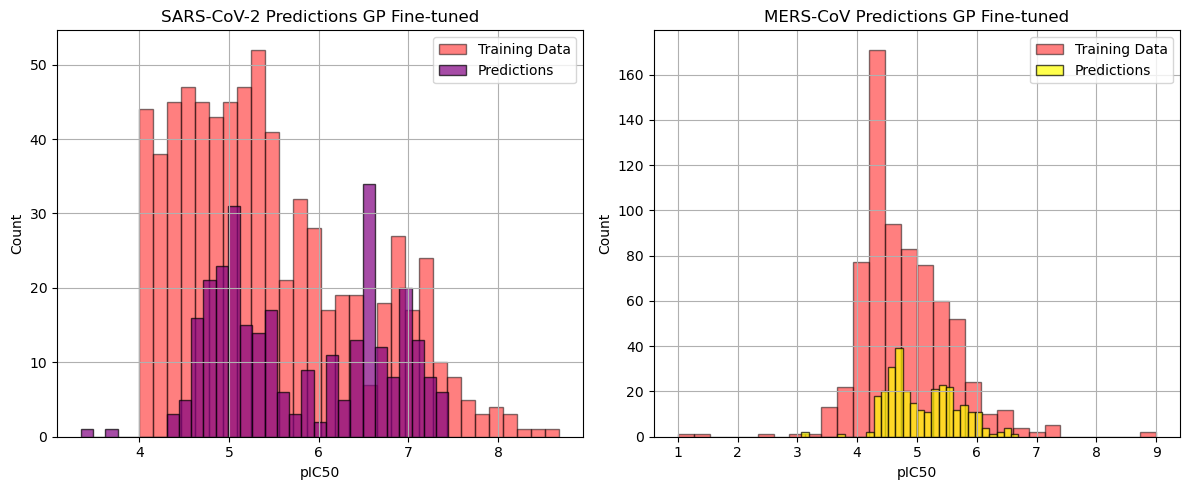

In [10]:
len(y_pred['pIC50 (SARS-CoV-2 Mpro)']), len(y_pred['pIC50 (MERS-CoV Mpro)'])

plt.figure(figsize=(12, 5))

# SARS-CoV-2 Predictions
plt.subplot(1, 2, 1)
plt.hist(Y_sars, bins=30, alpha=0.5, color='red', edgecolor='black', label='Training Data')
plt.hist(y_pred['pIC50 (SARS-CoV-2 Mpro)'], bins=30, alpha=0.7, color='purple', edgecolor='black', label='Predictions')
plt.title('SARS-CoV-2 Predictions GP Fine-tuned')
plt.xlabel('pIC50')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

# MERS-CoV Predictions
plt.subplot(1, 2, 2)
plt.hist(Y_mers, bins=30, alpha=0.5, color='red', edgecolor='black', label='Training Data')
plt.hist(y_pred['pIC50 (MERS-CoV Mpro)'], bins=30, alpha=0.7, color='yellow', edgecolor='black', label='Predictions')
plt.title('MERS-CoV Predictions GP Fine-tuned')
plt.xlabel('pIC50')
plt.ylabel('Count')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
len(var_sars)

297

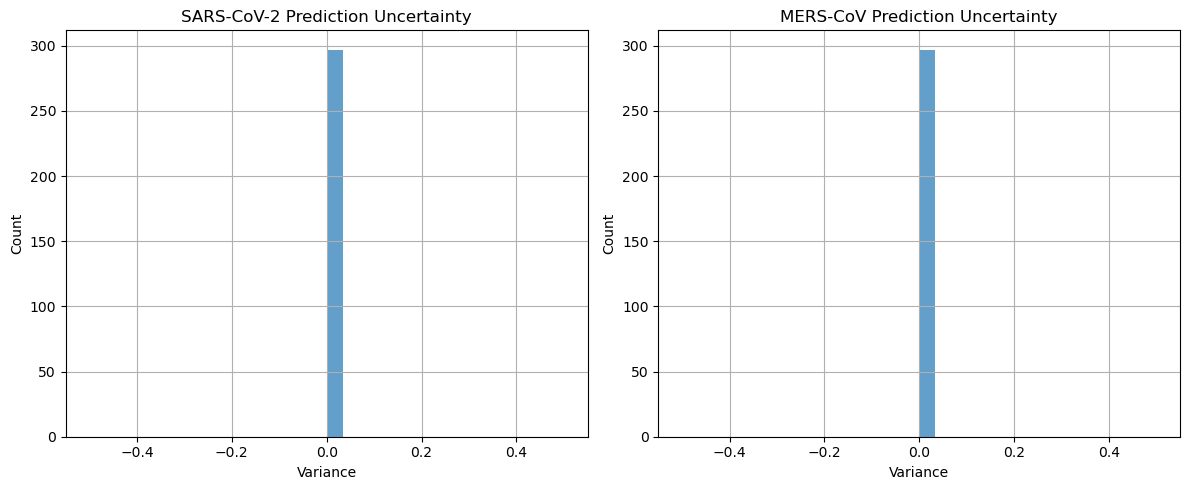

In [12]:

# -------------------------------------------------
# 7. Evaluate Uncertainty
# -------------------------------------------------

# Analyze prediction uncertainty
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(var_sars, bins=30, alpha=0.7)
plt.title('SARS-CoV-2 Prediction Uncertainty')
plt.xlabel('Variance')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(var_mers, bins=30, alpha=0.7)
plt.title('MERS-CoV Prediction Uncertainty')
plt.xlabel('Variance')
plt.ylabel('Count')
plt.grid(True)
plt.grid(True)


plt.tight_layout()
plt.show()


In [13]:

# -------------------------------------------------
# 8. Submit Predictions
# -------------------------------------------------

print("\nSubmitting predictions to competition...")
competition.submit_predictions(
    predictions=y_pred,
    prediction_name="gp-transfer-learning",
    prediction_owner="caithmac",  
    report_url="https://github.com/caithmac/polaris_potency_mpro", 
    description="GP model with transfer learning from 2k MPRO dataset, using Tanimoto kernel and 1500 epochs on fine-tuning",
    tags=["transfer-learning", "gp-regression", "tanimoto-kernel"],
    user_attributes={
        "Framework": "GPyTorch", 
        "Method": "Transfer Learning GP Regression",
        "Base Dataset": "MPRO 2k",
        "Kernel": "Tanimoto"
    }
)

print("Submission completed successfully!")


Submitting predictions to competition...


[16:28:39]  Success: Submitting competition predictions                                               ]8;id=953630;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=405717;file:///home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

Submission completed successfully!


In [14]:


# -------------------------------------------------
# 9. Save Models (Optional)
# -------------------------------------------------


# Move models to CPU before saving to make them device-agnostic
model_sars_cpu = model_sars.cpu()
likelihood_sars_cpu = likelihood_sars.cpu()
model_mers_cpu = model_mers.cpu()
likelihood_mers_cpu = likelihood_mers.cpu()

# Save trained models for future use
torch.save({
    'model_state_dict': model_sars.state_dict(),
    'likelihood_state_dict': likelihood_sars.state_dict(),
}, 'gp_sars_model.pth')

torch.save({
    'model_state_dict': model_mers.state_dict(),
    'likelihood_state_dict': likelihood_mers.state_dict(),
}, '/teamspace/studios/this_studio/DD/Polaris/saved_models/gp_mers_model.pth')

print("Models saved successfully.")

Models saved successfully.


In [15]:

# -------------------------------------------------
# 10. GPU Memory Management
# -------------------------------------------------

# Clean up GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory usage after cleanup: {torch.cuda.memory_allocated()/1024**2:.2f} MB")